<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/feature_generation_in_inorganic_materials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 無機材料の特徴量を生成する

### 右上の「接続」をクリックし、ランタイムに接続

## ライブラリをインストール

In [1]:
!pip uninstall -y scikit-image nx-cugraph-cu12 networkx thinc spacy fastai # 競合するライブラリを削除
!pip install pymatgen==2024.4.13 rdkit==2024.3.5 xenonpy==0.6.5

Found existing installation: scikit-image 0.25.2
Uninstalling scikit-image-0.25.2:
  Successfully uninstalled scikit-image-0.25.2
Found existing installation: nx-cugraph-cu12 25.2.0
Uninstalling nx-cugraph-cu12-25.2.0:
  Successfully uninstalled nx-cugraph-cu12-25.2.0
Found existing installation: networkx 3.4.2
Uninstalling networkx-3.4.2:
  Successfully uninstalled networkx-3.4.2
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: spacy 3.8.5
Uninstalling spacy-3.8.5:
  Successfully uninstalled spacy-3.8.5
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━

### 「ランタイム」タブから「セッションを再起動する」を選択し、「はい」をクリック

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、mp_data_formula_with_id_and_basic_physical_properties_1000.csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [3]:
import gc
import glob
import os

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from pymatgen.core import Composition
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from xenonpy.datatools import preset
from xenonpy.descriptor import Compositions

## データを読み込み、データフレームに格納

In [4]:
# mp_data_formula_with_id_and_basic_physical_properties_1000.csvを読み込む
df = pd.read_csv(
    INPUT_FILE_PATH + "mp_data_formula_with_id_and_basic_physical_properties_1000.csv"
)
df

,formula,id,band_gap,formation_energy,energy_above_hull
0,TeMoWSe2S,mp-1030190,0.0000,-0.425624,0.210342
1,Ca4Fe5(Si3O14)2,mp-1227865,0.0000,-2.382853,0.173176
2,MgSc2Ti2O7,mp-2218205,0.0000,-3.347469,0.189542
3,Mn4P4O13,mp-675297,3.6706,-2.485444,0.040228
4,Sc7Cl12,mp-23186,0.0000,-2.003680,0.014478
...,...,...,...,...,...
995,Hf2IrRu,mp-973434,0.0000,-0.858368,0.030086
996,K2Sr(NbCl3)6,mp-569413,1.0688,-1.920307,0.000000
997,Li9Mn2Co5O16,mp-1176275,0.9347,-1.846746,0.059682
998,TbIn7Cu5,mp-1217523,0.0000,-0.137104,0.057153


## 組成式を正規化して，元素ごとの割合の辞書であるcomp_dictを作成

In [5]:
# formulaを正規化(元素割合を足して1になるようにする)してcomp_dictを作成する関数
def get_fractional_composition(comp_str):
    try:
        comp = Composition(comp_str)
        return comp.fractional_composition.as_dict()
    except ValueError:
        return None

In [6]:
tqdm.pandas()
df["comp_dict"] = df["formula"].progress_apply(get_fractional_composition)

In [7]:
df

,formula,id,band_gap,formation_energy,energy_above_hull,comp_dict
0,TeMoWSe2S,mp-1030190,0.0000,-0.425624,0.210342,"{'Te': 0.16666666666666666, 'Mo': 0.1666666666..."
1,Ca4Fe5(Si3O14)2,mp-1227865,0.0000,-2.382853,0.173176,"{'Ca': 0.09302325581395349, 'Fe': 0.1162790697..."
2,MgSc2Ti2O7,mp-2218205,0.0000,-3.347469,0.189542,"{'Mg': 0.08333333333333333, 'Sc': 0.1666666666..."
3,Mn4P4O13,mp-675297,3.6706,-2.485444,0.040228,"{'Mn': 0.19047619047619047, 'P': 0.19047619047..."
4,Sc7Cl12,mp-23186,0.0000,-2.003680,0.014478,"{'Sc': 0.3684210526315789, 'Cl': 0.63157894736..."
...,...,...,...,...,...,...
995,Hf2IrRu,mp-973434,0.0000,-0.858368,0.030086,"{'Hf': 0.5, 'Ir': 0.25, 'Ru': 0.25}"
996,K2Sr(NbCl3)6,mp-569413,1.0688,-1.920307,0.000000,"{'K': 0.07407407407407407, 'Sr': 0.03703703703..."
997,Li9Mn2Co5O16,mp-1176275,0.9347,-1.846746,0.059682,"{'Li': 0.28125, 'Mn': 0.0625, 'Co': 0.15625, '..."
998,TbIn7Cu5,mp-1217523,0.0000,-0.137104,0.057153,"{'Tb': 0.07692307692307693, 'In': 0.5384615384..."


## 元素情報を取得

In [8]:
preset.sync("elements_completed")

fetching dataset `elements_completed` from https://github.com/yoshida-lab/dataset/releases/download/v0.1.3/elements_completed.pd.xz.


## comp_dict から組成由来の特徴量を生成

In [9]:
cal = Compositions()
descriptor = cal.transform(df["comp_dict"])
descriptor

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,42.000000,141.166667,233.500000,14.655000,99.565333,2452.004000,104.883333,477.333333,133.166667,124.333333,...,1.0,3.0,0.133,0.20500,180.0,182.0,215.0,305.2,2610.0,2.900
1,12.046512,146.596274,195.116279,14.411628,24.558581,940.379535,84.859748,325.013953,91.348837,86.604651,...,2.0,2.0,0.443,0.02658,152.0,150.0,182.0,291.2,317.5,0.802
2,12.833333,150.117495,206.416667,13.600000,26.828651,1276.860833,75.978524,523.825000,105.250000,95.666667,...,2.0,2.0,0.523,0.02658,152.0,150.0,182.0,302.1,317.5,0.802
3,12.571429,140.600879,194.428571,13.312381,26.268296,586.879524,72.065644,166.909524,89.809524,82.809524,...,2.0,2.0,0.477,0.02658,152.0,150.0,182.0,296.1,317.5,0.802
4,18.473684,152.749779,227.000000,17.336842,38.952177,1294.273684,21.694737,639.747368,127.052632,117.052632,...,2.0,3.0,0.556,0.00890,175.0,182.0,207.0,329.5,206.0,2.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,66.250000,151.000000,249.500000,11.010000,162.566750,4879.000000,190.000000,852.750000,159.250000,137.750000,...,1.0,5.0,0.133,23.00000,213.0,241.0,234.0,284.0,3010.0,7.600
996,23.259259,156.050693,220.777778,19.470370,50.420549,1412.437037,41.425203,727.325926,126.703704,120.037037,...,1.0,3.0,0.268,0.00890,175.0,182.0,207.0,316.5,206.0,2.180
997,10.625000,144.663210,197.187500,12.193125,22.593314,990.355937,76.771770,516.631250,99.937500,93.687500,...,1.0,2.0,0.456,0.02658,152.0,150.0,182.0,245.1,317.5,0.802
998,42.538462,152.461538,237.153846,12.661538,98.490873,2612.846154,99.465423,647.000000,142.153846,132.461538,...,1.0,4.0,0.183,11.00000,193.0,238.0,226.0,345.1,1215.0,6.200


In [10]:
descriptor_names = descriptor.columns.to_list()
descriptor_names

['ave:atomic_number',
 'ave:atomic_radius',
 'ave:atomic_radius_rahm',
 'ave:atomic_volume',
 'ave:atomic_weight',
 'ave:boiling_point',
 'ave:bulk_modulus',
 'ave:c6_gb',
 'ave:covalent_radius_cordero',
 'ave:covalent_radius_pyykko',
 'ave:covalent_radius_pyykko_double',
 'ave:covalent_radius_pyykko_triple',
 'ave:covalent_radius_slater',
 'ave:density',
 'ave:dipole_polarizability',
 'ave:electron_negativity',
 'ave:electron_affinity',
 'ave:en_allen',
 'ave:en_ghosh',
 'ave:en_pauling',
 'ave:first_ion_en',
 'ave:fusion_enthalpy',
 'ave:gs_bandgap',
 'ave:gs_energy',
 'ave:gs_est_bcc_latcnt',
 'ave:gs_est_fcc_latcnt',
 'ave:gs_mag_moment',
 'ave:gs_volume_per',
 'ave:hhi_p',
 'ave:hhi_r',
 'ave:heat_capacity_mass',
 'ave:heat_capacity_molar',
 'ave:icsd_volume',
 'ave:evaporation_heat',
 'ave:heat_of_formation',
 'ave:lattice_constant',
 'ave:mendeleev_number',
 'ave:melting_point',
 'ave:molar_volume',
 'ave:num_unfilled',
 'ave:num_valance',
 'ave:num_d_unfilled',
 'ave:num_d_vale

In [11]:
# dfとdescriptorを結合する
df = pd.concat([df, descriptor], axis=1)
df

,formula,id,band_gap,formation_energy,energy_above_hull,comp_dict,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
0,TeMoWSe2S,mp-1030190,0.0000,-0.425624,0.210342,"{'Te': 0.16666666666666666, 'Mo': 0.1666666666...",42.000000,141.166667,233.500000,14.655000,...,1.0,3.0,0.133,0.20500,180.0,182.0,215.0,305.2,2610.0,2.900
1,Ca4Fe5(Si3O14)2,mp-1227865,0.0000,-2.382853,0.173176,"{'Ca': 0.09302325581395349, 'Fe': 0.1162790697...",12.046512,146.596274,195.116279,14.411628,...,2.0,2.0,0.443,0.02658,152.0,150.0,182.0,291.2,317.5,0.802
2,MgSc2Ti2O7,mp-2218205,0.0000,-3.347469,0.189542,"{'Mg': 0.08333333333333333, 'Sc': 0.1666666666...",12.833333,150.117495,206.416667,13.600000,...,2.0,2.0,0.523,0.02658,152.0,150.0,182.0,302.1,317.5,0.802
3,Mn4P4O13,mp-675297,3.6706,-2.485444,0.040228,"{'Mn': 0.19047619047619047, 'P': 0.19047619047...",12.571429,140.600879,194.428571,13.312381,...,2.0,2.0,0.477,0.02658,152.0,150.0,182.0,296.1,317.5,0.802
4,Sc7Cl12,mp-23186,0.0000,-2.003680,0.014478,"{'Sc': 0.3684210526315789, 'Cl': 0.63157894736...",18.473684,152.749779,227.000000,17.336842,...,2.0,3.0,0.556,0.00890,175.0,182.0,207.0,329.5,206.0,2.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Hf2IrRu,mp-973434,0.0000,-0.858368,0.030086,"{'Hf': 0.5, 'Ir': 0.25, 'Ru': 0.25}",66.250000,151.000000,249.500000,11.010000,...,1.0,5.0,0.133,23.00000,213.0,241.0,234.0,284.0,3010.0,7.600
996,K2Sr(NbCl3)6,mp-569413,1.0688,-1.920307,0.000000,"{'K': 0.07407407407407407, 'Sr': 0.03703703703...",23.259259,156.050693,220.777778,19.470370,...,1.0,3.0,0.268,0.00890,175.0,182.0,207.0,316.5,206.0,2.180
997,Li9Mn2Co5O16,mp-1176275,0.9347,-1.846746,0.059682,"{'Li': 0.28125, 'Mn': 0.0625, 'Co': 0.15625, '...",10.625000,144.663210,197.187500,12.193125,...,1.0,2.0,0.456,0.02658,152.0,150.0,182.0,245.1,317.5,0.802
998,TbIn7Cu5,mp-1217523,0.0000,-0.137104,0.057153,"{'Tb': 0.07692307692307693, 'In': 0.5384615384...",42.538462,152.461538,237.153846,12.661538,...,1.0,4.0,0.183,11.00000,193.0,238.0,226.0,345.1,1215.0,6.200


## k-NNを使用したモデル適用範囲の検討

In [12]:
# 前半500個をtrain_df、残りをtest_dfとする
train_df = df[:500]
test_df = df[500:]

In [13]:
# スケーラーを定義
scaler_x = StandardScaler()
# スケーラーを適用
scaler_x.fit(train_df[descriptor_names])
X_train = scaler_x.transform(train_df[descriptor_names])
X_test = scaler_x.transform(test_df[descriptor_names])

In [14]:
k = 5  # k-NNの近傍点数
nbrs = NearestNeighbors(n_neighbors=k+1) # 自身を含めて k+1 個の近傍を計算
nbrs.fit(X_train)  # 正常データでモデルを学習

NearestNeighbors(n_neighbors=6)

In [15]:
# X_testに対して異常スコアを計算する
distances, _ = nbrs.kneighbors(X_test)
distances

array([[1.43477490e+01, 1.45185991e+01, 1.47466336e+01, 1.49273674e+01,
        1.55100019e+01, 1.58143016e+01],
       [5.47638169e+00, 9.98836183e+00, 1.00529298e+01, 1.05073894e+01,
        1.05484841e+01, 1.06035107e+01],
       [2.82760842e+00, 5.20079912e+00, 5.95070326e+00, 6.13935526e+00,
        6.20749951e+00, 6.37596591e+00],
       ...,
       [2.38418579e-07, 2.38418579e-07, 2.38418579e-07, 2.38418579e-07,
        2.38418579e-07, 6.13184550e-01],
       [7.37459301e+00, 1.00891189e+01, 1.11081957e+01, 1.23871918e+01,
        1.23967071e+01, 1.25208783e+01],
       [4.83213144e+00, 5.04183839e+00, 1.41854056e+01, 1.43928006e+01,
        1.44386297e+01, 1.44753198e+01]])

In [16]:
# k番目の近傍点までの距離を異常スコアとする
anomaly_scores = distances[:, -1]  # k番目の近傍点までの距離

In [17]:
# trainデータを基準に閾値を設定
threshold = np.percentile(nbrs.kneighbors(X_train)[0][:, -1], 95)
threshold

18.82959691360282

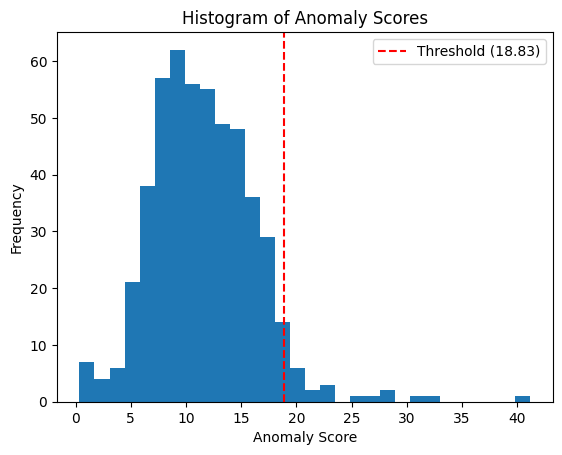

In [18]:
# 異常スコアのヒストグラムに赤色の点線でthresholdを描画
plt.hist(anomaly_scores, bins=30)
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Histogram of Anomaly Scores")
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})') # 閾値を赤色の点線で描画
plt.legend() #凡例を表示
plt.show()

In [19]:
# 異常スコアに基づいて異常フラグを作成
is_anomaly = anomaly_scores > threshold

# X_test の異常フラグをDataFrame化
anomaly_flags = pd.DataFrame({'anomaly_flag': is_anomaly}, index=test_df.index)

# 元データに異常フラグを追加
test_df_with_flags = pd.concat([test_df, anomaly_flags], axis=1)
test_df_with_flags['anomaly_flag'] = test_df_with_flags['anomaly_flag'].replace({False: '正常（モデル適用範囲内）', True: '異常（モデル適用範囲外）'})

# 異常フラグの集計
print(test_df_with_flags['anomaly_flag'].value_counts())

anomaly_flag
正常（モデル適用範囲内）    478
異常（モデル適用範囲外）     22
Name: count, dtype: int64


## 実行環境のライブラリverを保存

In [20]:
# Pythonのverを確認
!python3 -V

Python 3.11.12


In [21]:
!pip freeze > requirements_feature_generation_in_inorganic.txt

In [22]:
from google.colab import files

files.download('requirements_feature_generation_in_inorganic.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>